In [18]:
import cv2
import numpy as np
import torch
import RRDBNet_arch as arch
from skimage.restoration import denoise_wavelet
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_sauvola


In [5]:
# Load the model once globally
def load_esrgan_model(model_path='C:/Users/Nehal/Desktop/Ancient Text Processing/ESRGAN/models/RRDB_ESRGAN_x4.pth'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    torch.backends.cudnn.benchmark = True
    # Load the model
    model = arch.RRDBNet(3, 3, 64, 23, gc=32)
    model.load_state_dict(torch.load(model_path), strict=True)
    model.eval()
    model = model.to(device)
    return model

# Load the model once at the start





In [6]:
esrgan_model = load_esrgan_model()

cuda


C:\Users\Nehal\AppData\Local\Temp\ipykernel_316\2103832579.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path), strict=True)


In [7]:
def wavelet_denoising(image):
    denoised = denoise_wavelet(image, method='BayesShrink', mode='soft', wavelet_levels=4,
                               wavelet='db1', rescale_sigma=True)
    denoised = (denoised * 255).astype(np.uint8)
    return denoised

In [8]:
def apply_clahe(image, clip_limit=1.0, tile_grid_size=(4, 4)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    enhanced = clahe.apply(image)
    return enhanced

In [9]:
def enhance_text_image(image):
    denoised = wavelet_denoising(image)
    enhanced = apply_clahe(denoised)
    return enhanced

In [10]:
# Load the grayscale image
image = cv2.imread('C:/Users/Nehal/Desktop/Ancient Text Processing/sanskrit.png', cv2.IMREAD_GRAYSCALE)
enhanced_image = enhance_text_image(image)

# Save the contrast-enhanced image
cv2.imwrite('enhanced_text.png', enhanced_image)

True

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1295: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'


In [12]:




# ESRGAN Inference
def upscale_with_esrgan(image_path, model=esrgan_model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # print(device)
    # torch.backends.cudnn.benchmark = True
    # # Load the model
    # model = arch.RRDBNet(3, 3, 64, 23, gc=32)
    # model.load_state_dict(torch.load(model_path), strict=True)
    # model.eval()
    # model = model.to(device)

    # Preprocess the image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0  # Normalize to [0, 1]
    img = torch.from_numpy(np.transpose(img, (2, 0, 1))).float().unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img).squeeze(0).cpu().numpy()
    
    # Postprocess the output
    output = np.transpose(output, (1, 2, 0))
    output = (output * 255).clip(0, 255).astype(np.uint8)
    

    # Save the upscaled image
    cv2.imwrite('upscaled_text2.png', output)

# Upscale the enhanced image

# image = cv2.imread('upscaled_text.png')
# plt.imshow(image)
# plt.axis('off')  # Hide axes
# plt.show()

In [13]:
upscale_with_esrgan('enhanced_text.png')
cv2.imshow('Upscaled Image', cv2.imread('upscaled_text.png'))
cv2.waitKey(0)
cv2.destroyAllWindows()

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:973: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'


In [14]:
def adaptive_background_subtraction(image_path):
    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Estimate background using a smaller Gaussian Blur kernel (to retain text strokes better)
    background = cv2.GaussianBlur(img, (15, 15), 0)  # Reduced kernel size from (55,55) to (25,25)

    # Perform adaptive background subtraction
    text_foreground = cv2.divide(img, background,scale=255)  # Using subtraction instead of division

    # Apply CLAHE with reduced clipLimit to prevent over-enhancement of background
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(4, 4))  # Reduced clipLimit from 2.0 to 1.5
    enhanced_img = clahe.apply(text_foreground)

    return enhanced_img


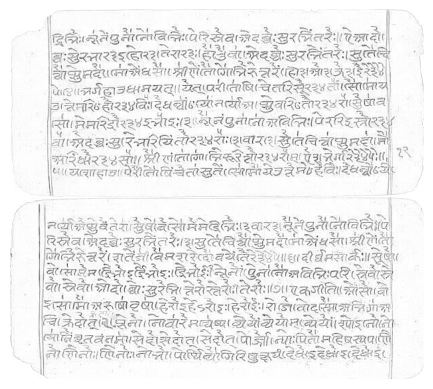

True

In [17]:
input_image_path = "upscaled_text2.png"  # Path to your upscaled image
processed_image = adaptive_background_subtraction(input_image_path)

# Display the processed image
plt.imshow(processed_image, cmap='gray')
plt.axis('off')
plt.show()

# Save the result
cv2.imwrite("cleaned_text_adaptive.png", processed_image)

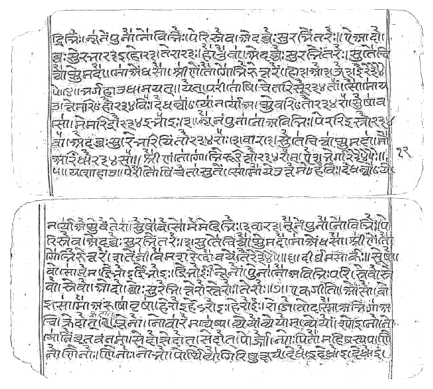

True

In [19]:
def sauvola_background_subtraction(image_path, window_size=45, k=1.5):
    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply Sauvola thresholding
    thresh_sauvola = threshold_sauvola(img, window_size=window_size, k=k)
    
    # Binarize image: Set pixels below the threshold to 0 (background) and others to 255 (text)
    binary_image = (img > thresh_sauvola).astype(np.uint8) * 255

    return binary_image

# Load and process the upscaled image
input_image_path = "cleaned_text_adaptive.png"  # Path to your upscaled image
processed_image = sauvola_background_subtraction(input_image_path, window_size=35, k=0.15)  # Adjust parameters as needed

# Display the processed image
plt.imshow(processed_image, cmap='gray')
plt.axis('off')
plt.show()

# Save the result
cv2.imwrite("cleaned_text_sauvola.png", processed_image)


In [26]:
upscale_with_esrgan('cleaned_text_sauvola.png')
cv2.imshow('Upscaled Image', cv2.imread('esrgan_2.png'))
cv2.waitKey(0)
cv2.destroyAllWindows()

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [27]:

import torch

torch.cuda.empty_cache()  # Frees unused memory
torch.cuda.ipc_collect()  # Forces collection of unused memory


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [29]:
import torch
import gc

# Delete all tensors to free GPU memory
for obj in list(globals().values()):
    if torch.is_tensor(obj):
        del obj

# Delete the model if it's taking memory
try:
    del esrgan_model
except NameError:
    pass

gc.collect()  # Force Python garbage collection
torch.cuda.empty_cache()  # Free unused memory
torch.cuda.ipc_collect()  # Ensure all memory is released


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


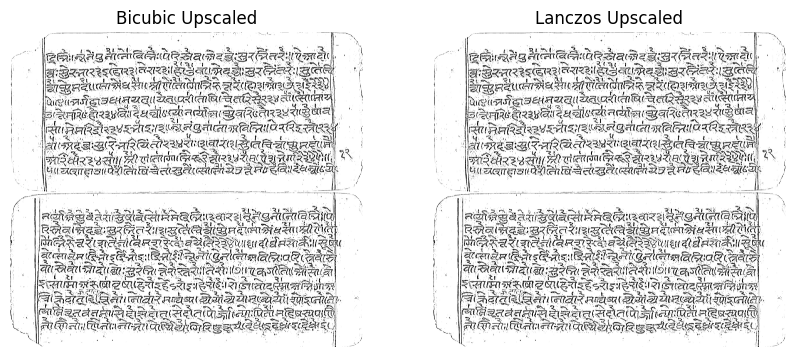

In [24]:


import cv2
import numpy as np

# Load the image
img = cv2.imread("C:/Users/Nehal/Desktop/Ancient Text Processing/new_pipeline/cleaned_text_sauvola.png")

# Define the scaling factor (e.g., 2x)
scale_factor = 2

# Apply Bicubic Interpolation
bicubic_upscaled = cv2.resize(img, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)

# Apply Lanczos Interpolation
lanczos_upscaled = cv2.resize(img, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_LANCZOS4)

# Save the results
cv2.imwrite("bicubic_upscaled.png", bicubic_upscaled)
cv2.imwrite("lanczos_upscaled.png", lanczos_upscaled)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(bicubic_upscaled)
plt.title("Bicubic Upscaled")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(lanczos_upscaled)
plt.title("Lanczos Upscaled")
plt.axis("off")

plt.show()


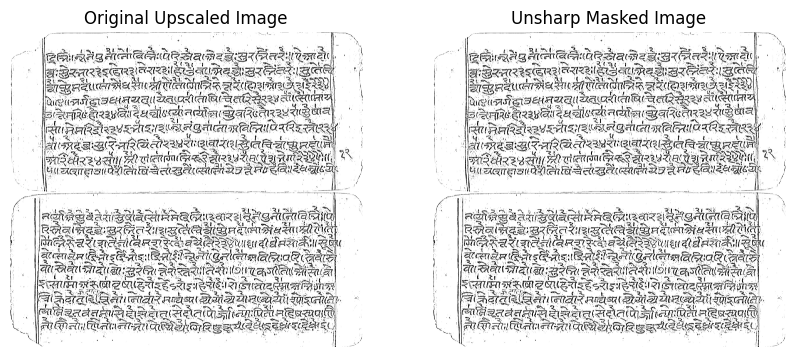

Sharpened text image saved as sharpened_text.png


In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the upscaled image
img = cv2.imread("lanczos_upscaled.png")  # Change filename if needed
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for Matplotlib

# Apply Gaussian Blur
blurred = cv2.GaussianBlur(img, (5, 5), 1.5)

# Compute Unsharp Masking
unsharp_mask = cv2.addWeighted(img, 1.5, blurred, -0.5, 0)  # 1.5 * Original - 0.5 * Blurred

# Display Results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Upscaled Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(unsharp_mask)
plt.title("Unsharp Masked Image")
plt.axis("off")

plt.show()

# Save the sharpened image
cv2.imwrite("sharpened_text.png", cv2.cvtColor(unsharp_mask, cv2.COLOR_RGB2BGR))
print("Sharpened text image saved as sharpened_text.png")
